In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Remove some warnings that pop up from pesky matplotlib
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Import the necessary libraries

%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import *
import sklearn
from math import *
from scipy.stats import norm
import math

## Here is an overview of the problem, as provided from the research paper <i>When and Why Are Deep Networks Better than Shallow Ones?</i> [1].

## I put these notes here to keep in mind when building the models to perform the analysis.  I won't follow the <u>exact</u> steps outlined in the paper but I will try to be close.

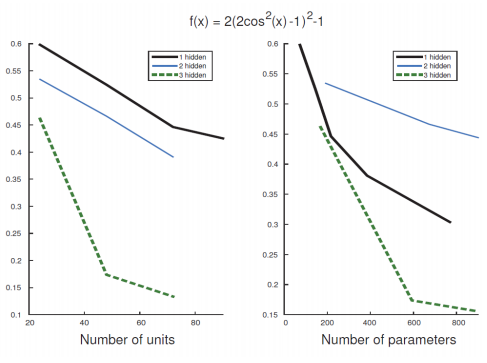

A sparse (because it has only a few of the possible terms) trigonometric polynomial f(x) = 2(2 cos^2(X) − 1)^2 − 1
(shown on the top of the figure) with one input variable is learned in a regression set-up using standard deep networks with 1,
2 or 3 hidden layers.<br>

In the their tests, they did the following:<br>

1. In the 1 hidden layer setting, 24, 48, 72, 128 and 256 hidden units were tried. 
2. With 2 hidden layers, 12, 24 and 36 units per layer were tried. 
3. With 3 hidden layers, 8, 16 and 24 units per layer were tried. Each of the above settings was repeated 5 times, reporting the lowest test error.

* Mean squared error (MSE) was used as the objective function; the y axes in the above figures are the square root of the testing MSE.

* For the experiments with 2 and 3 hidden layers, batch normalization was used between every two hidden layers. <span style="color:blue">(I skipped this step)</span><br>

* 60k training and 60k testing samples were drawn from a uniform distribution over [−2π, 2π].  <span style = "color:blue">(I will do this below)</span>.<br>

* The training process consisted of 2000 passes through the entire training data with mini batches of size 3000.  <span style = "color:blue">(I don't put them through in batch sizes.  When I first ran the models this lead to seeing the same MSE over and over.  I pass the entire dataset through for each epoch)</span><br>

* Stochastic gradient descent with momentum 0.9 and learning rate 0.0001 was used.  <span style = "color:blue">(This paper was likely written before the "Adam" optimizer became a thing.  I use this instead of the SGD optimizer and WHOA did my model's peformance improve.)</span>

#  A.  Data pre-processing and set up

In [4]:
## Create pi and cosine using numpy functions - so that I can actually create the data points
pi = np.pi
cos = np.cos

In [5]:
## Generate 120K data points using a (-2*pi, 2*pi) uniform distribution
X = np.random.uniform(-2*pi, 2*pi, 120000)

In [6]:
## Feed the X data points from the distribution in the y function to get my output
y = 2 * (2 * cos(X)**2 - 1) ** 2 - 1

In [7]:
## Split data training 50 % and testing 50%, just like they did in the test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [8]:
## Print the lengths of the training / testing split to confirm I have the right splits
print("The length of the training data set is: {}".format(len(X_train)))
print("The length of the testing data is : {}".format(len(X_test)))

The length of the training data set is: 60000
The length of the testing data is : 60000


## Plot the distribution of X to confirm a uniform distribution

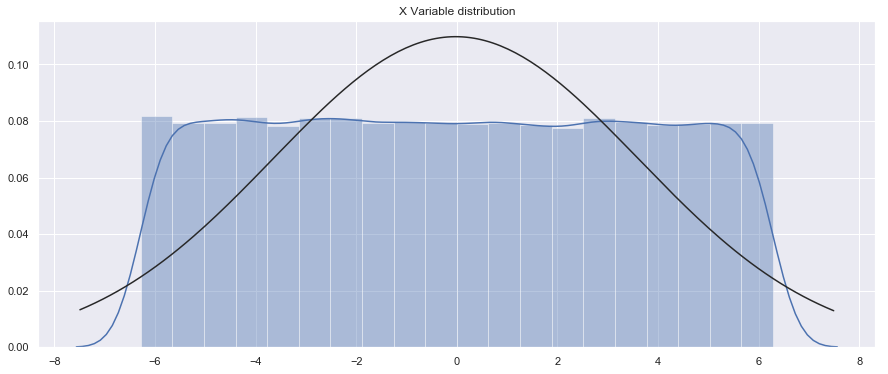

In [9]:
### Reset seaborn to the default background - for better viewing
sns.set()
    
# Build a new plot
plt.figure(1, figsize=(15, 6))

## Use a special function in seaborn to build a distribution plot and also include a 
sns.distplot(X_train, fit = norm, kde = True, bins = 20)

plt.title("X Variable distribution")

## Show the plot
plt.show()

## Plot a few of the data points combined to show the relationship between X and Y - What is our model trying to guess/predict?

In [285]:
## We grab the first twenty five data points (out of 120,000!!!) just to show the relationship between the data points

df = pd.DataFrame({"X": list(X)[0:25], 
                          "y": list(y)[0:25]},
                                 columns = ["X", "y"])

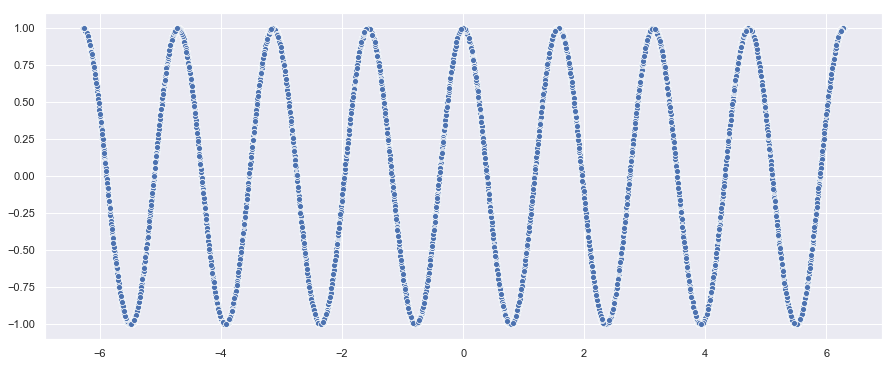

In [283]:
### Reset seaborn to the default background - for better viewing
sns.set()

# Build a new plot
plt.figure(1, figsize=(15, 6))

## Build a quick plot showing the relationship between the variables - looks like it will be a moving target!
sns.scatterplot(data = df, x=X, y=y)

## Show the plot
plt.show()

## Pretty waves - it might be difficult to try to guess where a random point lands based on this relationship though!

 

## <span style="color:blue">  As per our instructions, I will build and train 3 Neural Network models.

<span style="color:blue">  1.  Neural Network with 1 hidden layer<br>
<span style="color:blue">  2.  Neural Network with 2 hidden layers<br>
<span style="color:blue">  3.  Neural Network with 3 hidden layers

## <span style="color:blue"> I will use the Mean Squared Error as the `objective function` & `error measurement.`

## <span style="color:red">  An objective function is also known as a <i>loss function</i> (or optimization score function) and is one of the two parameters required to compile a model.

## <span style="color:red"> The error measurement is also known as a <i>metric function</i>; it is used to assess how well the models are performing.  Metric functions are supplied in the metrics parameter when a model is compiled.

# B.  Model creation and training

In [9]:
## Import our libraries needed to build the models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [34]:
## Confirm the shape of both our "features" and our target - this will influence what we need to input into the models
print(X_train.shape)

print()

print(y_train.shape)

(60000,)

(60000,)


In [141]:
## Based on the problem statement above, here is what they used.
## You see that they are commented out because I did not use these settings.

# learning_rate = 0.0001
# batch_size = 3000
# passes = 2000


## Here are the different hidden units that we want to use for the first model, which is one layer
## Choosing four values to showcase the difference in layers for each model - I selected these after a few different attempts
## 24, 48, 128, 256 hidden units
one_layer_nb_hiddens = np.array([24, 48, 128, 256])

# One Layer Neural Network Model - Very Shallow

## <span style="color:blue"> Note, a very confusing thing here is that the `shape` of the input to the model is defined as an argument on the first hidden layer.
    
## <span style="color:blue"> This means that the line of code that adds the first Dense layer is doing 2 things, defining the `input` or visible layer AND the first hidden layer.

In [142]:
## Create a function to build the one layer model
def test_model_one(activation='relu', nb_hidden = 120):
    
    ## Base model
    one_layer_model = Sequential()
    
    ## Add the one and only layer, we will cycle through the different hidden units, but keep the same activator constant
    one_layer_model.add(Dense(nb_hidden, input_dim = 1, activation = activation))
    
    ## Add the output layer, with one node and using the linear activation function
    one_layer_model.add(Dense(1, activation = "linear"))
    
    ## We will define the optimizer as the efficient stochastic gradient descent algorithm "adam". 
    ## This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.
    one_layer_model.compile(loss = "mse", optimizer = "adam", metrics = ["mse"])
    
    ## Return the completed model
    return one_layer_model

## <span style="color:blue"> Training occurs over epochs and each epoch is split into batches.
  
A.  `Epoch`: One pass through all of the rows in the training dataset. <br>
B.  `Batch`: One or more samples considered by the model within an epoch before weights are updated.  <span style="color:blue"> (This is the step that I skipped - the models would chunk out too much and not learn from the overall distribution of data points).
<br>

## <span style="color:blue"> One epoch is comprised of one or more batches, based on the chosen batch size and the model is fit for many epochs.

In [143]:
## Save our results to an empty list so that we can capture this and plot it later
one_layer_model_results = []

## Loop through all of the hidden layers and replace the hidden units in each iteration of tests
for i in one_layer_nb_hiddens:
    
    ## Establish a new version of our model above
    one_layer_model = test_model_one(nb_hidden = i)
    
    ## Save the history of the model and use 15% of the training data to validate our model results
    history = one_layer_model.fit(X_train, y_train, epochs = 20, verbose = 0, validation_split = 0.15)
    
    ## Save the results into the list above
    one_layer_model_results.append(history)

## <span style="color:blue"> Most of these configurations can be chosen experimentally by trial and error; I did a lot of this trial and error but removed all of those steps from the final write-up - most of it was incomprehensible code that would just be confusing. We want to train the model enough so that it learns a good (or good enough) mapping of rows of input data to the output classification.

## <span style="color:red"> The model will always have some error, but the amount of error will level out after some point for any given model configuration. This is called <i>model convergence</i>.

## Let's plot the results of the one layer model to see how it performs!

In [164]:
## Save our results to a new set of variables - so that we don't lose the history or the output from the first model run
first_run_loss = one_layer_model_results[0].history['loss']
second_run_loss = one_layer_model_results[1].history['loss']
third_run_loss = one_layer_model_results[2].history['loss']
fourth_run_loss = one_layer_model_results[3].history['loss']
    
## Save the results of our validation MSE as well - whichever does the best from the three will get trained and tested again with the actual test data
first_run_mse = one_layer_model_results[0].history['val_mse']
second_run_mse = one_layer_model_results[1].history['val_mse']
third_run_mse = one_layer_model_results[2].history['val_mse']
fourth_run_mse = one_layer_model_results[3].history['val_mse']

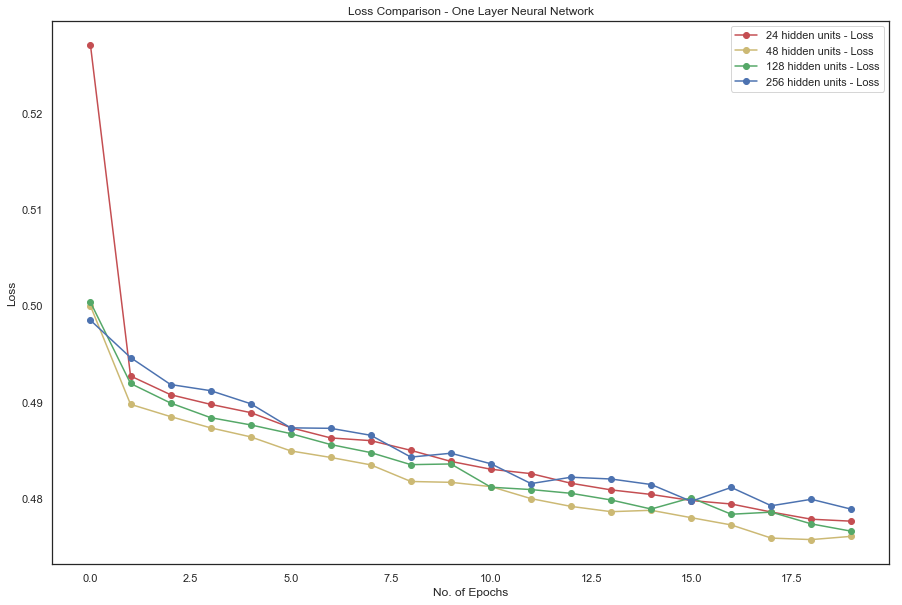

In [193]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot loss to quickly visual the best performing one layer model
plt.plot(first_run_loss, 'r-o', label = "24 hidden units - Loss")
plt.plot(second_run_loss, 'y-o', label = "48 hidden units - Loss")
plt.plot(third_run_loss, 'g-o', label = "128 hidden units - Loss")
plt.plot(fourth_run_loss, 'b-o', label = "256 hidden units - Loss")

## Give some descriptive labels
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

## Title and legend
plt.title("Loss Comparison - One Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

## <span style="color:blue"> The first thing we notice about the one layer model is that it doesn't change much from epoch to epoch.  The model doesn't have much to learn from since the layer doesn't go very deep, even with 256 hidden units.  The loss stays around the same baseline, hovering around .5.

## <span style="color:red"> The most interesting about the one layer model is that the best performing model (as far as performance goes) is the one with 48 hidden units, and not the model with 256 hidden units.  We would have "expected" the model with more hidden units to perform better, but it did not in this case.

## Let's compare the model's validation Mean Squared Error, which was both the model's objective function and what we using to evaluate the model performance.

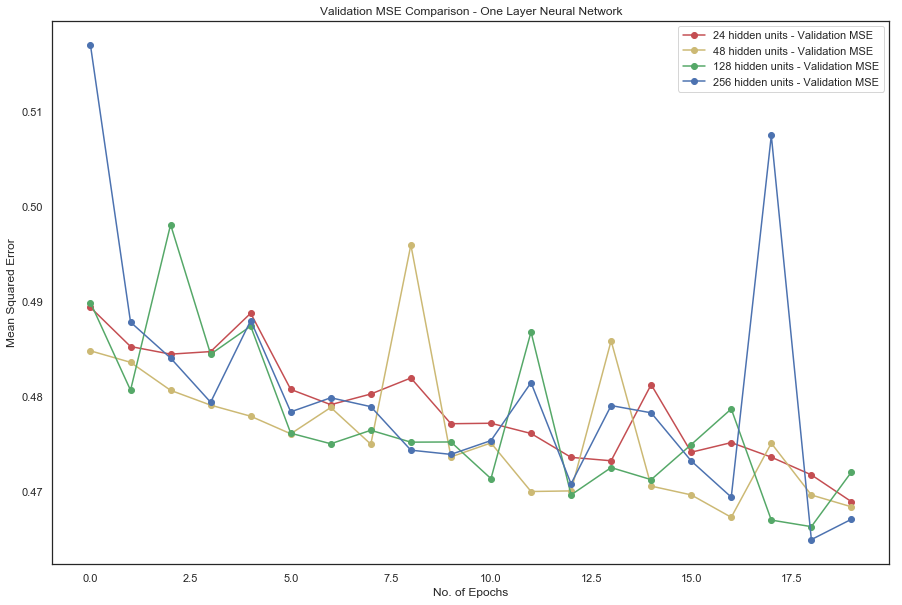

In [194]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot validation Mean Squared Error to quickly visual the best performing model
plt.plot(first_run_mse, 'r-o', label = "24 hidden units - Validation MSE")
plt.plot(second_run_mse, 'y-o', label = "48 hidden units - Validation MSE")
plt.plot(third_run_mse, 'g-o', label = "128 hidden units - Validation MSE")
plt.plot(fourth_run_mse, 'b-o', label = "256 hidden units - Validation MSE")

## Give some descriptive labels
plt.xlabel("No. of Epochs")
plt.ylabel("Mean Squared Error")

## Title and legend
plt.title("Validation MSE Comparison - One Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

## <span style="color:blue"> A few observations of our one layer NN:

## <span style="color:blue"> 1.  Our 256 hidden unit model certainly has some interesting behavior - there is a massive spike in MSE on the 17th training cycle.

## <span style="color:blue"> 2.  We see a lot of fluctuations in the Validation Mean Squared Error from epoch to epoch.  

## <span style="color:red"> 3.  We also notice that our MSE doesn't improve much with a one layer model, even after 20 training epochs - it never falls below 0.47.  We're going to create a new model with another layer and see how well it performs.

In [293]:
print("The lowest MSE that our one layer model reaches is {}".format(min(fourth_run_mse)))

The lowest MSE that our one layer model reaches is 0.4649650752544403


# Two Layer Model - A Little <span style="color:maroon">Deeper</span>

## <span style="color:blue"> The two layer model looks very similar to the first; the only addition is another layer, which you see in the function below.  Everything else will stay the same, and I will test it similarly like I tested the one layer model.

In [10]:
## Cycle through these different hidden units with our two layer model - renamed it since we'll be keeping this the same for the three layer model as well.

nb_hiddens = np.array([24, 48, 128, 256])

In [11]:
## Create a function to build the two layer model
def test_model_two(activation='relu', nb_hidden = 120):
    
    two_layer_model = Sequential()
    
    ## The first hidden layer will cycle through different hidden layers
    ## The model expects rows of data with 1 variable (the input_dim=1 argument)
    two_layer_model.add(Dense(nb_hidden, input_dim = 1, activation = "relu"))
    
    ## The second hidden layer will have the same number of hidden units as the first layer and uses the relu activation function.
    two_layer_model.add(Dense(nb_hidden, activation = "relu"))
    
    ## The output layer has one node and uses the linear activation function.
    two_layer_model.add(Dense(1, activation = "linear"))
    
    ## We will define the optimizer as the efficient stochastic gradient descent algorithm "adam". 
    ## This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.
    two_layer_model.compile(loss = "mse", optimizer = "adam", metrics = ["mse"])
    
    ## Return the completed model
    return two_layer_model

In [12]:
## Save our results to an empty list so that we can capture this and plot it later
two_layer_model_results = []

## Loop through all of the hidden layers and replace the hidden units in each iteration of tests
for i in nb_hiddens:
    
    ## Establish a new version of our model above
    two_layer_model = test_model_two(nb_hidden = i)
    
    ## Save the history of the model and use 15% of the training data to validate our model results
    history = two_layer_model.fit(X_train, y_train, epochs = 20, verbose = 0, validation_split = 0.15)
    
    ## Save the results into the list above
    two_layer_model_results.append(history)

In [13]:
## Save our results to a new set of variables - so that we don't lose the history or the output from the first model run
first_run_loss_b = two_layer_model_results[0].history['loss']
second_run_loss_b = two_layer_model_results[1].history['loss']
third_run_loss_b = two_layer_model_results[2].history['loss']
fourth_run_loss_b = two_layer_model_results[3].history['loss']

## Save the results of our validation MSE as well - whichever does the best from the three will get tested with the actual data
first_run_mse_b = two_layer_model_results[0].history['val_mse']
second_run_mse_b = two_layer_model_results[1].history['val_mse']
third_run_mse_b = two_layer_model_results[2].history['val_mse']
fourth_run_mse_b = two_layer_model_results[3].history['val_mse']

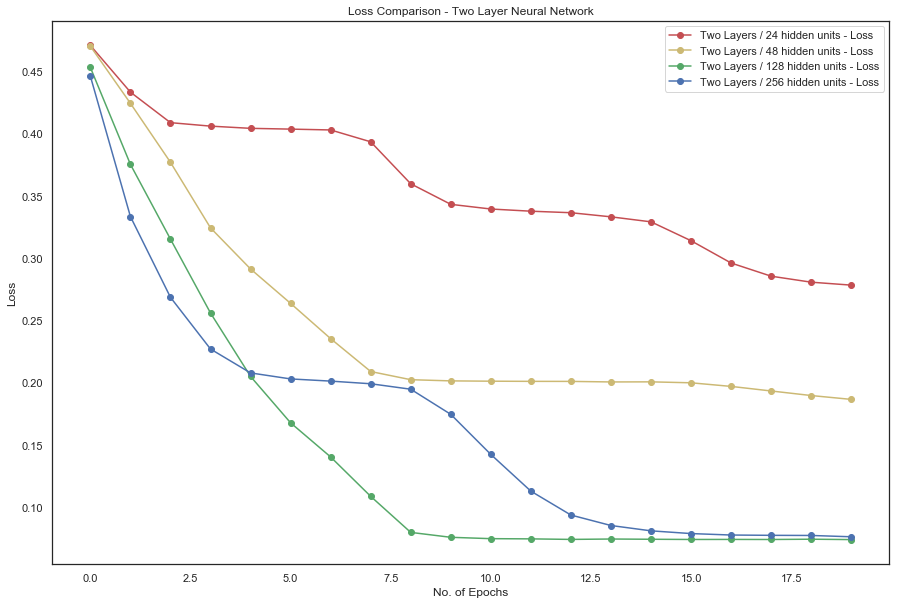

In [192]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot loss to quickly visual the best performing two layer model
plt.plot(first_run_loss_b, 'r-o', label = "Two Layers / 24 hidden units - Loss")
plt.plot(second_run_loss_b, 'y-o', label = "Two Layers / 48 hidden units - Loss")
plt.plot(third_run_loss_b, 'g-o', label = "Two Layers / 128 hidden units - Loss")
plt.plot(fourth_run_loss_b, 'b-o', label = "Two Layers / 256 hidden units - Loss")

## Give some descriptive labels
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

## Title and legend
plt.title("Loss Comparison - Two Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

## <span style="color:blue"> Already we see a vast improvement with a two layer deep neural network.  The information gained from the second layer gets passed to the first, so the model has more of an opportunity to learn.  This is reflected in the fact that the loss gradually drops after the first ten epochs before starting to level out, as the model can't keep doing any better.
    
## <span style="color:red"> Again, here we observe an interesting pattern - the two layer NN with 128 hidden units <i>slightly</i> outperforms the model with 256 hidden units - maybe this is a case or an argument to say that more hidden units isn't always going to lead to better performance?

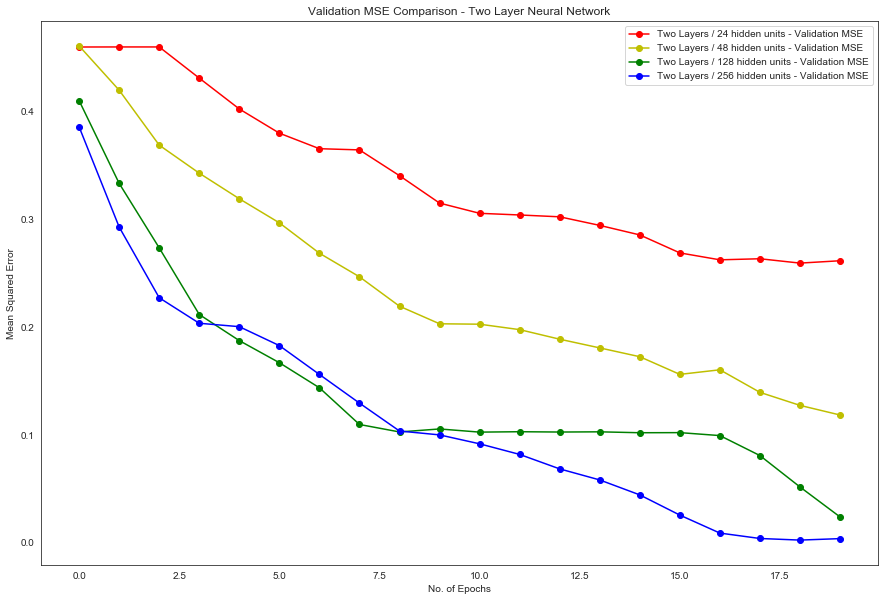

In [14]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot Mean Squared Error to quickly visual the best performing two layer model
plt.plot(first_run_mse_b, 'r-o', label = "Two Layers / 24 hidden units - Validation MSE")
plt.plot(second_run_mse_b, 'y-o', label = "Two Layers / 48 hidden units - Validation MSE")
plt.plot(third_run_mse_b, 'g-o', label = "Two Layers / 128 hidden units - Validation MSE")
plt.plot(fourth_run_mse_b, 'b-o', label = "Two Layers / 256 hidden units - Validation MSE")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Mean Squared Error")

## Title and legend
plt.title("Validation MSE Comparison - Two Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

## <span style="color:blue"> When we look at the validation Mean Squared Error scores, we see that the second layer model does much better!  We're seeing significant improvement in the Mean Squared Error scores with more training epochs.  This means that the model is actually learning and getting better at making predictions.  The errors that the two layer NN makes get smaller and smaller with more chances/opportunities to learn.
    
## <span style="color:red"> And unlike our plot above, we see that the model with 256 units does much better when actually making predictions (because it has a much smaller MSE than the result of the models).

## Three Layer Model - Does <span style="color:maroon"><i>Deeper</i></span> Mean <span style="color:gold">Better</span>?

## <span style="color:blue"> The three layer model is identical to the first two, but with yet ANOTHER additional layer (which you see in the function below).  Everything else stays the same.

In [185]:
def test_model_three(activation='relu', nb_hidden = 120):
    
    three_layer_model = Sequential()
    
    ## The first hidden layer will cycle through different hidden units
    ## The model expects rows of data with 1 variable (the input_dim=1 argument)
    three_layer_model.add(Dense(nb_hidden, input_dim = 1, activation = activation))
    
    ## The second hidden layer will have the same number of hidden units as the first layer and uses the relu activation function.
    three_layer_model.add(Dense(nb_hidden, activation = "relu"))
    
    ## The third hidden layer will have the same number of hidden units as the first layer and uses the relu activation function.
    three_layer_model.add(Dense(nb_hidden, activation = "relu"))
    
    ## The output layer has one node and uses the sigmoid activation function.
    three_layer_model.add(Dense(1, activation = "linear"))
    
    ## We will define the optimizer as the efficient stochastic gradient descent algorithm “adam“. 
    ## This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.
    three_layer_model.compile(loss = "mse", optimizer = "adam", metrics = ["mse"])
    
    ## Return the completed model
    return three_layer_model

In [187]:
## Save our results to an empty list so that we can capture this and plot it later
three_layer_model_results = []

## Loop through all of the hidden layers and replace the hidden units in each iteration of tests
for i in nb_hiddens:
    
    ## Establish a new version of our model above
    three_layer_model = test_model_three(activation='relu', nb_hidden = i)
    
    ## Save the history of the model and use 15% of the training data to validate our model results
    history = three_layer_model.fit(X_train, y_train, verbose = 0, epochs = 20, validation_split = 0.15)
    
    ## Save the results into the list above
    three_layer_model_results.append(history)

In [188]:
## Save our results to a new set of variables - so that we don't lose the history or the output from the first model run
first_run_loss_c = three_layer_model_results[0].history['loss']
second_run_loss_c = three_layer_model_results[1].history['loss']
third_run_loss_c = three_layer_model_results[2].history['loss']
fourth_run_loss_c = three_layer_model_results[3].history['loss']

## Save the results of our validation MSE as well - whichever does the best from the three will get tested with the actual data
first_run_mse_c = three_layer_model_results[0].history['val_mse']
second_run_mse_c = three_layer_model_results[1].history['val_mse']
third_run_mse_c = three_layer_model_results[2].history['val_mse']
fourth_run_mse_c = three_layer_model_results[3].history['val_mse']

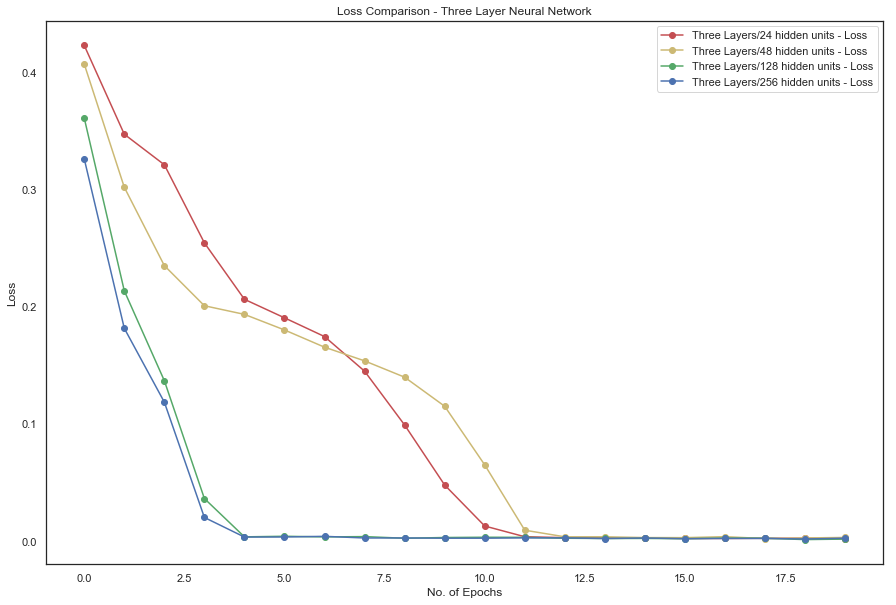

In [195]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot loss to quickly visual the best performing three layer model
plt.plot(first_run_loss_c, 'r-o', label = "Three Layers/24 hidden units - Loss")
plt.plot(second_run_loss_c, 'y-o', label = "Three Layers/48 hidden units - Loss")
plt.plot(third_run_loss_c, 'g-o', label = "Three Layers/128 hidden units - Loss")
plt.plot(fourth_run_loss_c, 'b-o', label = "Three Layers/256 hidden units - Loss")


## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

## Title and legend
plt.title("Loss Comparison - Three Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

## <span style="color:blue"> We see that the three layer neural network is starting to show signs of DEEP overfitting.  Unlike the first model with one layer, this one has a chance to go very deep into the "rabbit hole" - so much so that it gets almost "too" good and minimizes the loss function to almost zilch (zero).

## <span style="color:red"> Another thing happening here is that after the twelfth epoch, all four versions of the three layer model converge (meet); that means that after twelve training cycles, it doesn't matter how many hidden units we use - once we have created a NN with three layers, even 24 hidden units is enough for the model to plunge its loss function to almost zero.

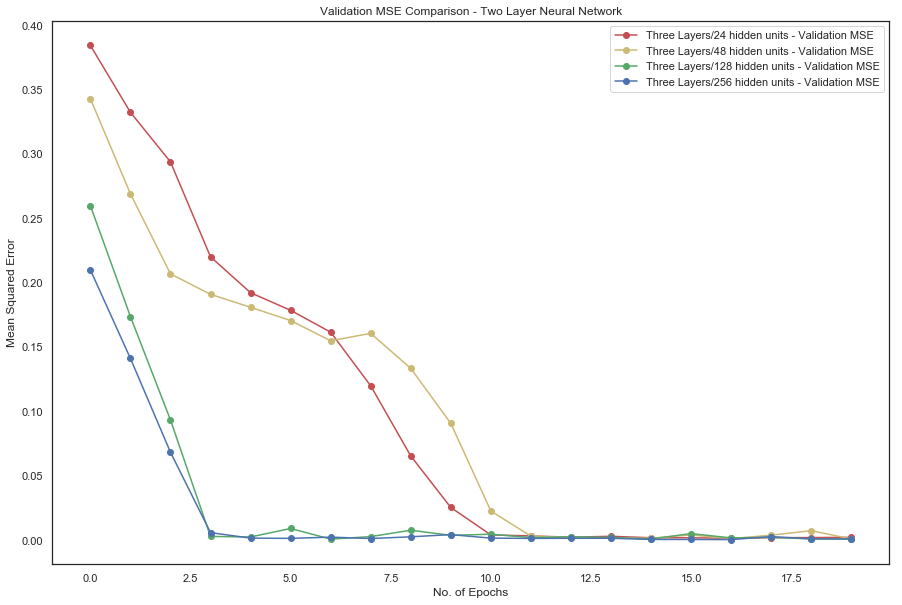

In [196]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Set the figure size    
plt.figure(figsize= (15, 10))

## This is WITHOUT having changed any of the default parameters
plt.plot(first_run_mse_c, 'r-o', label = "Three Layers/24 hidden units - Validation MSE")
plt.plot(second_run_mse_c, 'y-o', label = "Three Layers/48 hidden units - Validation MSE")
plt.plot(third_run_mse_c, 'g-o', label = "Three Layers/128 hidden units - Validation MSE")
plt.plot(fourth_run_mse_c, 'b-o', label = "Three Layers/256 hidden units - Validation MSE")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Mean Squared Error")

## Title and legend
plt.title("Validation MSE Comparison - Two Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

## <span style="color:blue">  Pretty similar conclusions can be drawn from the testing Mean Squared Error for our three layer NN.  After twelve epochs all of them converge and start producing very low MSE - which means the models are doing a good job of predicting values without making errors.
    
## For our final trick, we'll compare the best versions of each NN.

# C.  Show the performance difference of 3 different versions of Neural Networks

## <span style="color:blue"> What I am going to do now is take the three best Neural Network models, the first with one layer, the second with two layers, and the third with three layers.

##  <span style="color:blue"> I will then re-train the model with the best configuration using the <u>testing</u> data as my validation set; I set this apart at the very beginning of the process, for the specific purpose of seeing how the models would perform with data they had not seen before.  The reasoning behind this is my models are now ready to compete against each other, for the title of deepest, smartest neural network.
    
## <span style="color:red"> In addition, I will capture the ROOT mean squared error after these runs to see how well it improves over time.  This metric (which, you guessed it, is just the square root of the MSE), is what I will ultimately use to gauge the effectiveness of the three models.

In [198]:
## NB Hidden Units - One Layer - 48
## NB Hidden Units - Two Layers - 128
## NB Hidden Units - Three Layers - 256

## Create another empty list to store the final results
final_test_results = []

## Establish a new version of our model above
testing_one_layer_model = test_model_one(nb_hidden = 48)
    
## Save the history of the model
testing_history = testing_one_layer_model.fit(X_train, y_train, epochs = 20, verbose = 0, 
                                              validation_data = (X_test, y_test))  ## Validate using the testing data

## Save the results into the list above
final_test_results.append(testing_history)

In [200]:
## Establish a new version of our two layer model above
testing_two_layer_model = test_model_two(nb_hidden = 128)
    
    ## Save the history of the model
testing_history = testing_two_layer_model.fit(X_train, y_train, epochs = 20, verbose = 0, 
                                              validation_data = (X_test, y_test))  ## Validate using the testing data
    
## Save the results into the list above
final_test_results.append(testing_history)

In [202]:
## Establish a new version of our three layer model above
testing_three_layer_model = test_model_three(nb_hidden = 256)
    
    ## Save the history of the model
testing_history = testing_three_layer_model.fit(X_train, y_train, epochs = 20, verbose = 0, 
                                              validation_data = (X_test, y_test))  ## Validate using the testing data
    
## Save the results into the list above
final_test_results.append(testing_history)

## Graph the final comparison results

In [203]:
## Save all of the output to separate lists - this will be helpful for plotting the results later
## It's important that we show both the training and testing loss, now that we're using the actual testing data for performance comparisons

## Loss across the three different neural networks
one_hidden_layer_loss = final_test_results[0].history['loss']
two_hidden_layer_loss = final_test_results[1].history['loss']
three_hidden_layer_loss = final_test_results[2].history['loss']

## Testing (validation) Loss across the three different neural networks
one_hidden_layer_val_loss = final_test_results[0].history['val_loss']
two_hidden_layer_val_loss = final_test_results[1].history['val_loss']
three_hidden_layer_val_loss = final_test_results[2].history['val_loss']

## MSE across the three different neural networks
one_hidden_layer_mse = final_test_results[0].history['mse']
two_hidden_layer_mse = final_test_results[1].history['mse']
three_hidden_layer_mse = final_test_results[2].history['mse']

## Testing (validation0 MSE across the three different neural networks
one_hidden_layer_val_mse = final_test_results[0].history['val_mse']
two_hidden_layer_val_mse = final_test_results[1].history['val_mse']
three_hidden_layer_val_mse = final_test_results[2].history['val_mse']

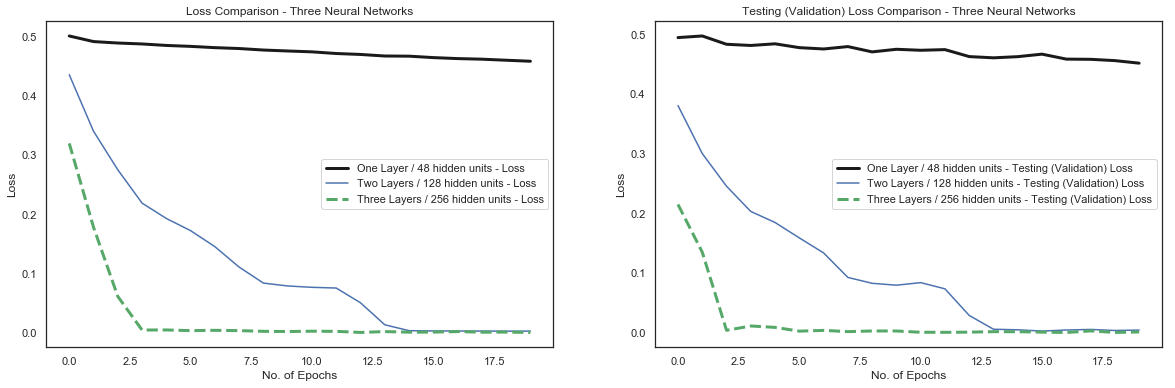

In [227]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Create two new sub plots so we can show the training and validation performance side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

## Save the new plots as variables to save us typing below
ax1 = axes[0]
ax2 = axes[1]

## Plot the loss on our three neural networks to compare how well they performed
ax1.plot(one_hidden_layer_loss, 'k', lw = 3, label = "One Layer / 48 hidden units - Loss")
ax1.plot(two_hidden_layer_loss, 'b', label = "Two Layers / 128 hidden units - Loss")
ax1.plot(three_hidden_layer_loss, 'g--', lw = 3, label = "Three Layers / 256 hidden units - Loss")

## Set the title, add x/y labels, and a legend for the first plot
ax1.set_title("Loss Comparison - Three Neural Networks")
ax1.set_xlabel("No. of Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(one_hidden_layer_val_loss, 'k', lw = 3, label = "One Layer / 48 hidden units - Testing (Validation) Loss")
ax2.plot(two_hidden_layer_val_loss, 'b', label = "Two Layers / 128 hidden units - Testing (Validation) Loss")
ax2.plot(three_hidden_layer_val_loss, 'g--', lw = 3, label = "Three Layers / 256 hidden units - Testing (Validation) Loss")

ax2.set_title("Testing (Validation) Loss Comparison - Three Neural Networks")
ax2.set_xlabel("No. of Epochs")
ax2.set_ylabel("Loss")
ax2.legend(loc = 'right')

## Show the beautiful graph
plt.show()

##  <span style="color:black">  I did my best to recreate the plots that were in the write-up referenced at the beginning of the analysis.  What are we trying to show here?
    
## <span style="color:blue">  On the left plot, we see a comparison of the loss function between the three networks.  We observe that the one layer network doesn't perform that great, even after twenty repetition to try to learn the data.  The two and three layer NN immediately start paying dividends after about three or four epochs.  After about fourteen, they end up converging.
    
## <span style="color:red"> On the right plot, we see a comparison of the loss function on the testing data (the subset of data we had left behind at the beginning).  Here, we see pretty similar behavior, the one layer NN gets stuck right around .5, while the two / three layer models start learning and performing better pretty much right away, before meeting up again at the thirteenth/fourteenth epoch.

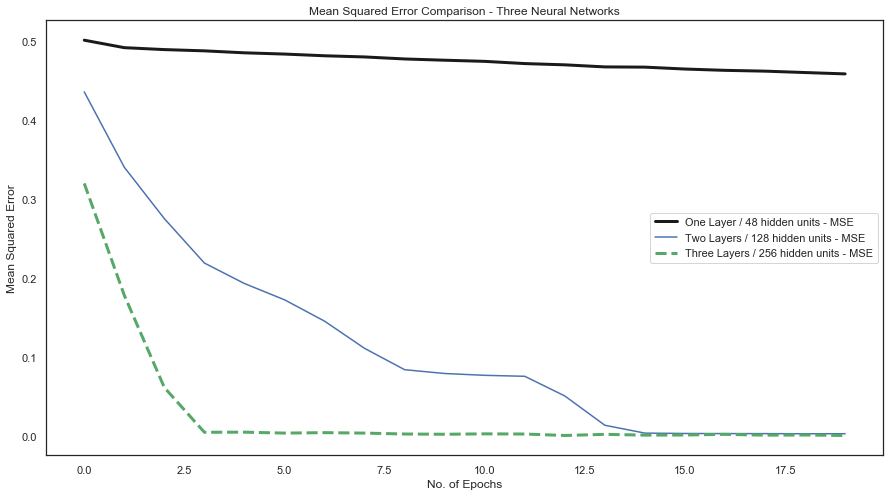

In [255]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Set the figure size    
plt.figure(figsize= (15, 8))

## Plot the loss on our three neural networks to compare how well they performed
plt.plot(one_hidden_layer_mse, 'k', lw = 3, label = "One Layer / 48 hidden units - MSE")
plt.plot(two_hidden_layer_mse, 'b', label = "Two Layers / 128 hidden units - MSE")
plt.plot(three_hidden_layer_mse, 'g--', lw = 3, label = "Three Layers / 256 hidden units - MSE")

## Set the title, add x/y labels, and a legend for the first plot
plt.title("Mean Squared Error Comparison - Three Neural Networks")
plt.xlabel("No. of Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()

## Show the beautiful graph
plt.show()

##  <span style="color:blue"> I only plot the MSE here because the two and three layer models do SO well that they start to have MSE close to zero; this makes for an unfair comparison to the poor one layer NN model stuck at .5,  and also makes it difficult to visualize.

## <span style="color:red"> Since it is really hard to tell <i>just</i> how well the two and three layer models are performing, I create a final set of plots below, using the Root Mean Squared Error, so that we can truly observe the difference in the three networks.

In [256]:
## Import the square root function from math library
from math import sqrt

## Calculate the Root MSE for the one layer NN
plot_one_layer_rmse = [sqrt(i) for i in one_hidden_layer_val_mse]

## Calculate the Root MSE for the two layer NN
plot_two_layer_rmse = [sqrt(i) for i in two_hidden_layer_val_mse[10:20]]

## Calculate the Root MSE for the three layer NN
plot_three_layer_rmse = [sqrt(i) for i in three_hidden_layer_val_mse[10:20]]

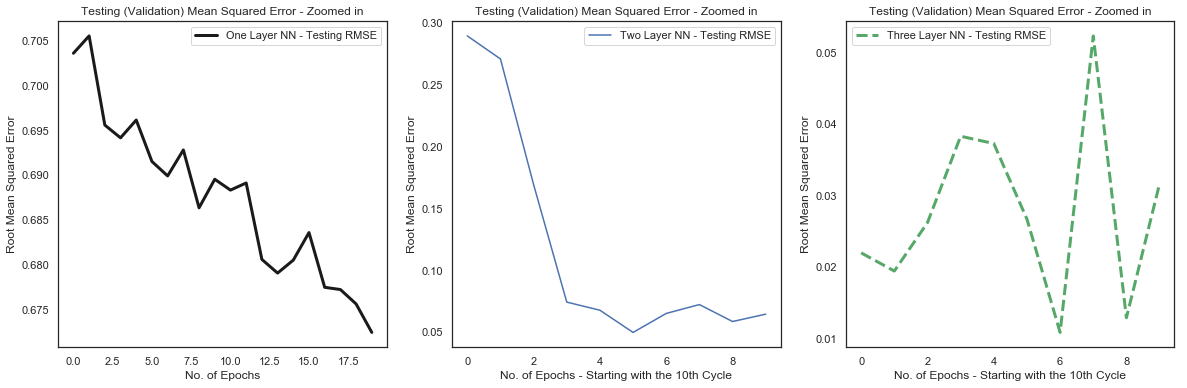

In [262]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Create two new sub plots so we can show the training and validation performance side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

## Save the new plots as variables to save us typing below
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

## Plot the loss on our three neural networks to compare how well they performed
#ax1.plot(one_hidden_layer_val_mse, 'k', lw = 3, label = "One Layer NN - Testing RMSE")
ax1.plot(plot_one_layer_rmse, 'k', lw = 3, label = "One Layer NN - Testing RMSE")

## Set the title, add x/y labels, and a legend for the first plot
ax1.set_title("Testing (Validation) Mean Squared Error - Zoomed in")
ax1.set_xlabel("No. of Epochs")
ax1.set_ylabel("Root Mean Squared Error")
ax1.legend()

## Plot the loss on our three neural networks to compare how well they performed
#ax2.plot(two_hidden_layer_val_mse[10:20], 'b', label = "Two Layer NN - Testing RMSE")
ax2.plot(plot_two_layer_rmse, 'b', label = "Two Layer NN - Testing RMSE")

## Set the title, add x/y labels, and a legend for the second plot
ax2.set_title("Testing (Validation) Mean Squared Error - Zoomed in")
ax2.set_xlabel("No. of Epochs - Starting with the 10th Cycle")
ax2.set_ylabel("Root Mean Squared Error")
ax2.legend()

## Plot the loss on our three neural networks to compare how well they performed
#ax3.plot(three_hidden_layer_val_mse[10:20], 'g--', lw = 3, label = "Three Layer NN - Testing RMSE")
ax3.plot(plot_three_layer_rmse, 'g--', lw = 3, label = "Three Layer NN - Testing RMSE")

## Set the title, add x/y labels, and a legend for the second plot
ax3.set_title("Testing (Validation) Mean Squared Error - Zoomed in")
ax3.set_xlabel("No. of Epochs - Starting with the 10th Cycle")
ax3.set_ylabel("Root Mean Squared Error")
ax3.legend()

## Show the beautiful graph
plt.show()

##  <span style="color:red"> Much better!  Now we can <i>really</i> see what is happening to our error as the models have more and more training applied.
    
## <span style="color:black">  The first plot shows that the one layer NN gradually learns throughout the training cycles but never gets below 0.675.
    
## <span style="color:blue">  The second plot shows that the two layer NN (after the tenth training epoch - I start from this point so the plot doesn't get skewed by the first few runs) keeps learning until about the fourteenth trip through and then starts to level off.  Most importantly, however, it stays pretty consistent from here.
    
## <span style="color:green">  The third plot shows that the three layer NN (after the tenth training epoch - I start from this point so the plot doesn't get skewed by the first few runs) has already learned what it needed to learn from almost the very beginning.  The unfortunate side effect of this is that it starts to behave erratically - the three layer model is likely overfitting by this point, and doing so well that the RMSE is miniscule.

## Out of the three final evaluation models, I would probably stick with the two layer model; based on the output above, it doesn't seem to have the opportunity to overfit and start demonstrating uneven performance at the end of twenty training epochs, like the three layer model was demonstrating.  We can conclude that deeper may not ALWAYS be better, and that it is important to put steps in place to prevent your model from overfitting.  Some things that can help this include:

* Adding [dropout](https://github.com/keras-team/keras/blob/master/keras/layers/core.py#L81) (dropping a portion of the dataset)
* [Batch normalization](https://keras.io/layers/normalization/)
* Less hidden units when using multi-layered NN

## <span style="color:gold"> Thank you for reading my analysis!

[1]  Liao, Q., Mhaskar H. & Poggio, T.  (2017).  <i>When and Why Are Deep Networks Better than Shallow Ones?</i> (Proceedings of the Thirty-First AAAI Conference on Artificial Intelligence).  Retreived November 17, 2019 from AAAI Publications: https://www.aaai.org/ocs/index.php/AAAI/AAAI17/paper/viewPaper/14849